In [42]:
%load_ext autoreload
%autoreload 2
import urllib.request
import tarfile
import numpy as np
import random
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unet import UNet
from tqdm import tqdm
from metrics_loss import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [44]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

CUDA Available: True
Using device: cuda


In [45]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"
large_dataset = True # set to false if you want small dataset (0k images vs 10k images)
download = False # specify true if you want to download data

In [46]:
if download is True:
    os.makedirs(data_dir, exist_ok=True)
    
    voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
    voc_name = "pascal_voc.tar"
    voc_name = os.path.join(data_dir, voc_name)
    
    urllib.request.urlretrieve(voc_url, voc_name)
    
    with tarfile.open(voc_name) as tar:
        tar.extractall(path=data_dir)

In [47]:
if large_dataset is True and download is True: 
    aug_data_dir = "sbd_dat_mat"
    os.makedirs(aug_data_dir, exist_ok=True)
    
    aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
    aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')
    
    # Downloading the file from the URL
    urllib.request.urlretrieve(aug_url, aug_name)
    
    with tarfile.open(aug_name) as tar:
        tar.extractall(path=aug_data_dir)

In [48]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
img_size = 256 # pass in your image size
resize = "resize" # choose resizing method, "random_crop" which takes a random crop from the image, or use "resize" which scales the image down
# random crop preserves pixel level info while losing the whole picture, while resize keeps the whole picture, but may distort pixel level info

if resize == "random_crop":
    aug_list = Compose([RandomCrop(img_size)])
    img_size = "same"
else:
    aug_list = Compose([])
    
pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
if large_dataset is True:
    pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE")
    split_train = "train_aug"
    split_val = "train_aug_val"
else:
    pascal_augment = None
    split_train = "train"
    split_val = "val"
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_train, is_transform=True, img_size=img_size, augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_val, is_transform=True, img_size=img_size, augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

Using large dataset (Pascal VOC + SBD)
Using large dataset (Pascal VOC + SBD)


In [49]:
len(val_dataset)

904

In [50]:
freq = torch.zeros(len(train_dataset.get_pascal_labels()))
total = torch.zeros(1)
for img, mask in train_dataset:
    indices, counts = mask.unique(return_counts=True)
    for index, count in zip(indices, counts):
        freq[index] += count
    total += sum(counts)
freq = freq / total
print(freq)

tensor([0.7020, 0.0093, 0.0081, 0.0090, 0.0070, 0.0057, 0.0134, 0.0203, 0.0306,
        0.0124, 0.0058, 0.0103, 0.0271, 0.0090, 0.0115, 0.0735, 0.0059, 0.0067,
        0.0117, 0.0131, 0.0075])


In [51]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 32  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [52]:
vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    print(mask[0].unique())
    print(mask[0].shape)
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

tensor([0, 4])
torch.Size([256, 256])
tensor([0, 8])
torch.Size([256, 256])
tensor([0, 3])
torch.Size([256, 256])
tensor([ 0,  9, 11, 18])
torch.Size([256, 256])
tensor([ 0, 12])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


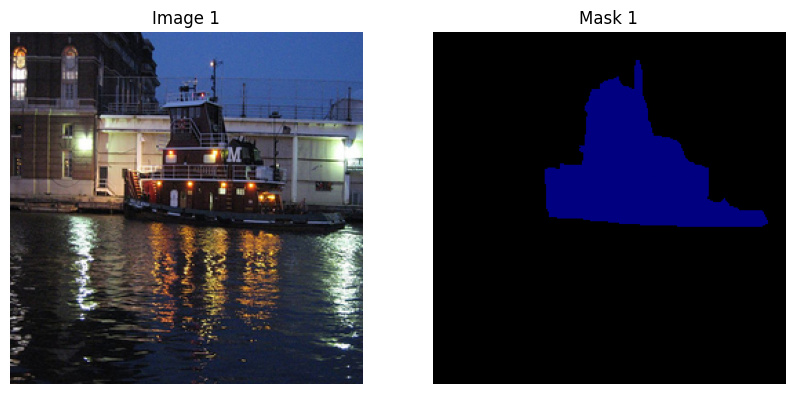

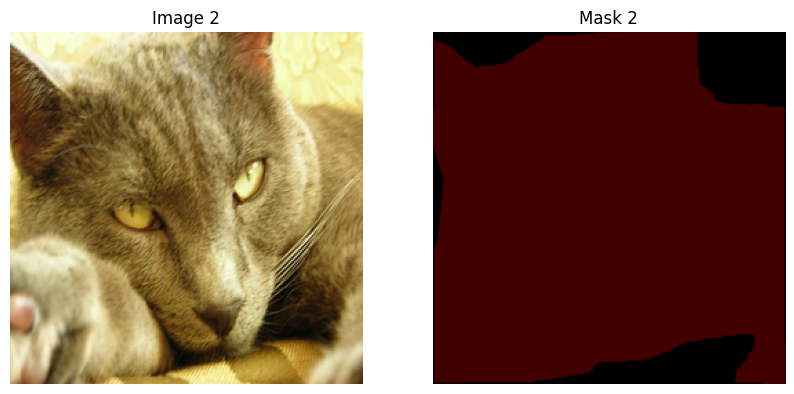

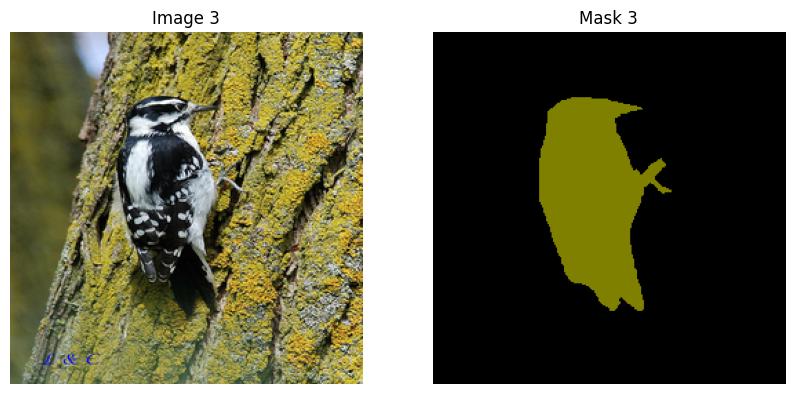

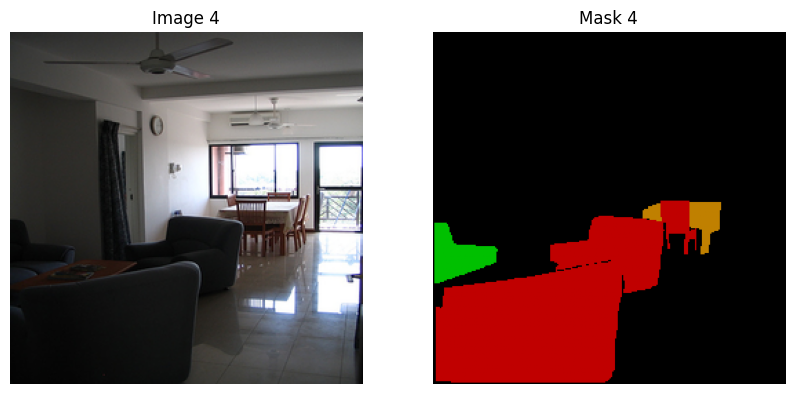

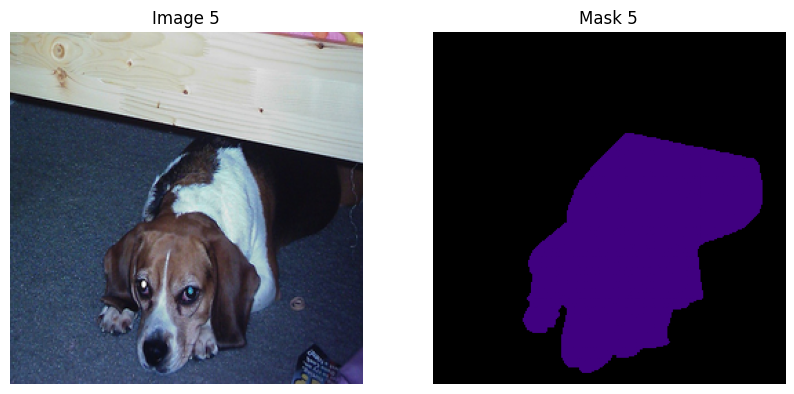

In [53]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.
    
    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)

In [54]:
torch.cuda.empty_cache()

In [81]:
# Check for CUDA availability
from metrics_loss import dice_acc, DiceLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        
# Initialize the model
model = UNet(3, 21, [64, 128, 256])

# Move the model to the CUDA device if available
model = model.to(device)
class_weights = (1/(freq))**0.8
print(class_weights)
class_weights = class_weights.to(device)
criterion = ClassBalancedFocalCELoss(gamma=2, weights=class_weights)
# criterion = torch.nn.CrossEntropyLoss(weight=freq.to(device))
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
epochs = 5
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Using device: cuda
tensor([ 1.3272, 42.2195, 46.9492, 43.1782, 53.0525, 62.0104, 31.5475, 22.6279,
        16.2813, 33.6090, 61.6811, 38.7496, 17.9157, 43.1836, 35.5243,  8.0677,
        60.9310, 54.8417, 35.0645, 32.0256, 50.2255])


In [82]:
print(model)

UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): 

In [83]:
# Training and validation code
from metrics_loss import pixel_acc, dice_acc
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_pixel_acc = batch_dice_acc = 0.0

    for img, mask in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        loss = criterion(outs, mask)
        loss.backward()
        optimizer.step()

        with torch.no_grad(): 
            batch_loss += loss.item()
            batch_pixel_acc += pixel_acc(outs, mask).item()
            batch_dice_acc += dice_acc(outs, mask).item()
            
    batch_loss /= len(train_loader)
    batch_pixel_acc /= len(train_loader)
    batch_dice_acc /= len(train_loader)
    
    print(f"Training loss: {batch_loss}, Dice accuracy: {batch_dice_acc}, Pixel accuracy: {batch_pixel_acc}")
    model.eval()
    val_loss = val_pixel_acc = val_dice_acc = 0.0

    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = img.to(device), mask.to(device)

            outs = model(img)
            loss = criterion(outs, mask)
            val_loss += loss.item()
            val_pixel_acc += pixel_acc(outs, mask).item()
            val_dice_acc += dice_acc(outs, mask).item()

    val_loss /= len(val_loader)
    val_pixel_acc /= len(val_loader)
    val_dice_acc /= len(val_loader)
    print(f"Validation loss: {val_loss}, Dice accuracy: {val_dice_acc}, Pixel Accuracy: {val_pixel_acc}")

EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 276/276 [01:17<00:00,  3.57it/s]


Training loss: 1498057.342164855, Dice accuracy: 0.015128873792254244, Pixel accuracy: 0.33941780905360763


Validation Loop, Epoch: 0: 100%|██████████| 29/29 [00:03<00:00,  9.64it/s]


Validation loss: 1468613.6810344828, Dice accuracy: 0.015526153821626613, Pixel Accuracy: 0.20443383578596444
EPOCH 1:


Training Loop, Epoch: 1: 100%|██████████| 276/276 [01:17<00:00,  3.56it/s]


Training loss: 1367741.4495018115, Dice accuracy: 0.01972846066970648, Pixel accuracy: 0.35638445550980774


Validation Loop, Epoch: 1: 100%|██████████| 29/29 [00:02<00:00,  9.71it/s]


Validation loss: 1321745.8168103448, Dice accuracy: 0.018254905810643887, Pixel Accuracy: 0.3253299778905408
EPOCH 2:


Training Loop, Epoch: 2: 100%|██████████| 276/276 [01:17<00:00,  3.57it/s]


Training loss: 1291252.2022192029, Dice accuracy: 0.02311406534610559, Pixel accuracy: 0.37913727749517


Validation Loop, Epoch: 2: 100%|██████████| 29/29 [00:03<00:00,  9.59it/s]


Validation loss: 1258652.7629310344, Dice accuracy: 0.020109840058561028, Pixel Accuracy: 0.35163114810812063
EPOCH 3:


Training Loop, Epoch: 3: 100%|██████████| 276/276 [01:17<00:00,  3.57it/s]


Training loss: 1230206.699728261, Dice accuracy: 0.026005876733098125, Pixel accuracy: 0.3883168833411258


Validation Loop, Epoch: 3: 100%|██████████| 29/29 [00:03<00:00,  9.60it/s]


Validation loss: 1200949.2995689656, Dice accuracy: 0.02720765833710802, Pixel Accuracy: 0.3912836929847454
EPOCH 4:


Training Loop, Epoch: 4: 100%|██████████| 276/276 [01:17<00:00,  3.57it/s]


Training loss: 1183486.2943840579, Dice accuracy: 0.02920472019932408, Pixel accuracy: 0.39756265444600064


Validation Loop, Epoch: 4: 100%|██████████| 29/29 [00:03<00:00,  9.66it/s]

Validation loss: 1210141.7198275863, Dice accuracy: 0.02699040923396061, Pixel Accuracy: 0.445608402120656


In [ ]:
vis_length = 5
imgs = []
masks = []
model = model.to('cpu')
for index, (img, mask) in enumerate(val_loader):
    img = img[0].unsqueeze(0)
    mask = mask[0]
    outs = model(img)  # (NCHW)
    outs = torch.argmax(outs, dim=1)  # NHW
    outs = outs.squeeze(0)
    print(index, torch.unique(outs, return_counts=True))
    print(index, torch.unique(mask, return_counts=True))
    mask_decoded = val_dataset.decode_segmap(mask.numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    outs_decoded = val_dataset.decode_segmap(outs.numpy())
    imgs.append(torch.tensor(outs_decoded).permute(2, 0, 1))
    if len(imgs) == 5:
        break
visualize_image_and_mask_tensors(imgs, masks)